In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
from ecco_v4_py import vector_calc, scalar_calc

import gsw
import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [2]:
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

# Select a dataset (the one containing temperature and salinity)
dataset_num = 22

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
Vel_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
Vel_dataset_files = np.sort(list(Vel_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in Vel_dataset_files[:5]])

# Select a dataset (the one containing temperature and salinity)
dataset_num = 16

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
dens_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
dens_dataset_files = np.sort(list(dens_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in dens_dataset_files[:5]])

selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_VOLUME_FLUX

First 5 files
['OCEAN_VOLUME_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_DENS_STRAT_PRESS

First 5 files
['OCEAN_DENS_STRAT_PRESS_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_DENS_STRAT_PRESS_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_DENS_STRAT_PRESS_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_DENS_STRAT_PRESS_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_DENS_STRAT_PRESS_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']


In [4]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:45545") #find within Scheduler Address with orange red squares)
client.ncores
client.restart()

In [7]:
start_time = time.time();
ds_dens = None
ds_vel = None

files_to_load = Vel_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_vel = xr.open_mfdataset(Vel_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
files_to_load = dens_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_dens = xr.open_mfdataset(dens_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})


total_time = time.time() - start_time

lazy-loading 336 granules
lazy-loading 336 granules


In [8]:
geom_path = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_geom = xr.open_dataset(geom_path)

In [9]:
ecco_ds = xr.merge((ds_geom , ds_dens['RHOAnoma'],ds_vel[['UVELMASS','VVELMASS']]))

In [10]:
density = ds_dens['RHOAnoma']

(<Figure size 900x900 with 25 Axes>,
 array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]))

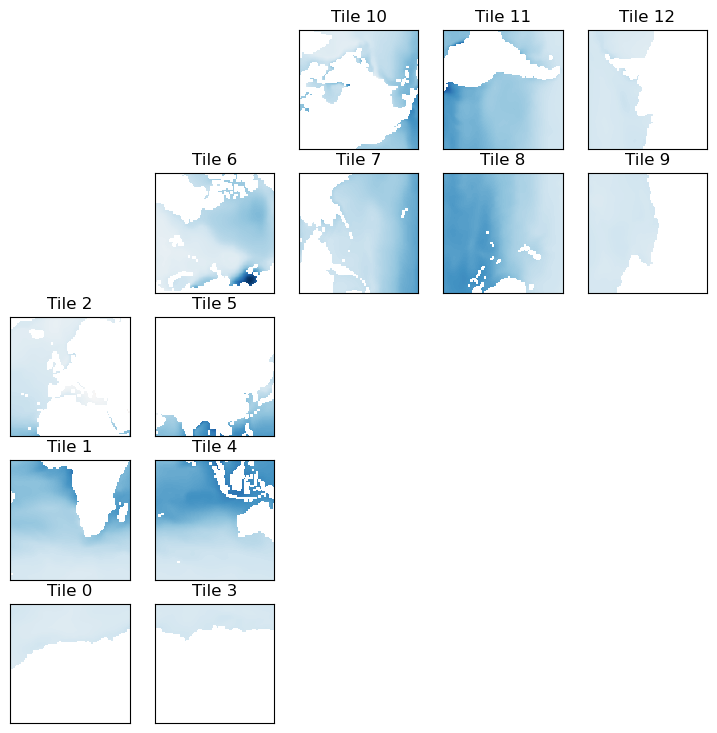

In [11]:
ecco.plot_tiles(density.isel(k=0).isel(time=0))

In [12]:
vel_trial = ds_vel.UVELMASS[0,:,10,70,70].load()
rho_trial = density[0,:,10,70,70].load()
vel_trial

<xarray.DataArray 'UVELMASS' (k: 50)> Size: 200B
array([ 7.5072558e-03,  8.9498470e-03,  9.5804613e-03,  9.4900541e-03,
        9.1728410e-03,  8.9691877e-03,  8.8081881e-03,  9.0194363e-03,
        9.1468068e-03,  6.6166366e-03,  7.0488453e-03,  4.8515508e-03,
        4.7395062e-03,  4.2650881e-03,  4.0693129e-03,  4.0845419e-03,
        3.8529539e-03,  3.6892081e-03,  3.5300050e-03,  3.2373525e-03,
        2.8546450e-03,  2.4205660e-03,  1.8763297e-03,  1.1523556e-03,
        4.0766783e-04, -5.6970839e-05, -2.0840837e-04, -2.3615023e-04,
       -2.0992062e-04, -1.0725260e-04,  5.0099428e-05,  2.3152106e-04,
        4.2724534e-04,  5.9097062e-04,  6.4785097e-04,  5.0674879e-04,
        1.5649668e-04, -2.1014659e-04, -3.7484945e-04, -1.7267998e-04,
        3.1854218e-04,  8.3163689e-04,  1.2888248e-03,  1.6075301e-03,
        1.7539698e-03,  1.8234412e-03,  1.6643131e-03,  1.2980072e-03,
        1.1181389e-03,            nan], dtype=float32)
Coordinates:
    i_g      int32 4B 70
    j        int32 4B 70
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    tile     int32 4B 10
    time     datetime64[ns] 8B 1992-01-16T18:00:00
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
Attributes:
    valid_min:              -0.71189505
    valid_max:              0.8394877
    coverage_content_type:  modelResult
    direction:              >0 increases volume
    long_name:              Horizontal velocity in the model +x direction per...
    units:                  m s-1
    comment:                Horizontal velocity in the model +x direction ave...

In [13]:
target_sig_levels = np.arange(-11,26,.5)

In [14]:
vel_dens = np.interp(target_sig_levels, rho_trial.values, vel_trial.values,left= np.nan,right= np.nan)

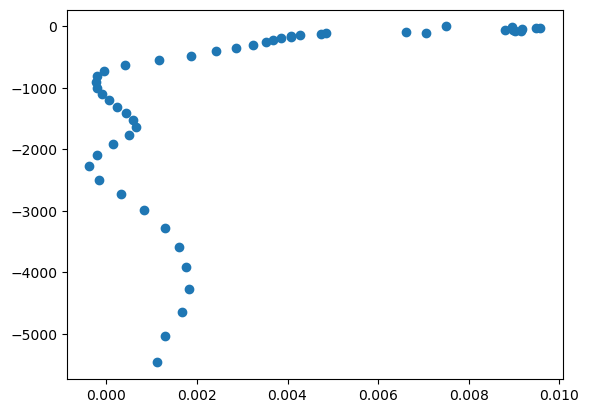

In [15]:
plt.scatter(vel_trial,vel_trial.Z)

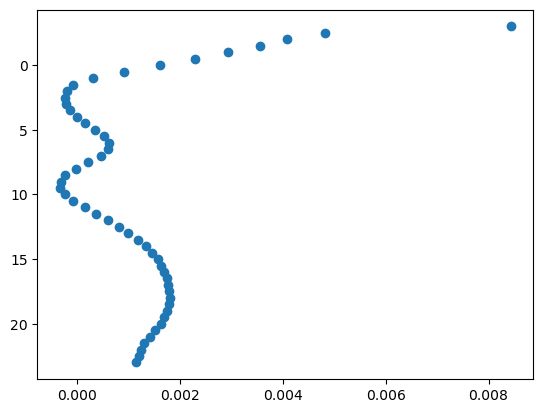

In [16]:
plt.scatter(vel_dens,target_sig_levels)
plt.gca().invert_yaxis()

In [17]:
#pick a latitude
# Get array of 1's at and north of latitude
lat = 45
ones = xr.ones_like(ecco_ds.YC)
dome_maskC = ones.where(ecco_ds.YC>=lat,0).compute()

In [18]:
maskC = ds_geom.maskC.compute()
maskS = ds_geom.maskS.compute()
maskW = ds_geom.maskW.compute()

In [19]:
grid = ecco.get_llc_grid(ecco_ds)

In [20]:
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [21]:
exp_mask = np.abs(lat_maskW.values + lat_maskS.values)
exp_mask = np.where(np.abs(exp_mask)>0, 1, 0)

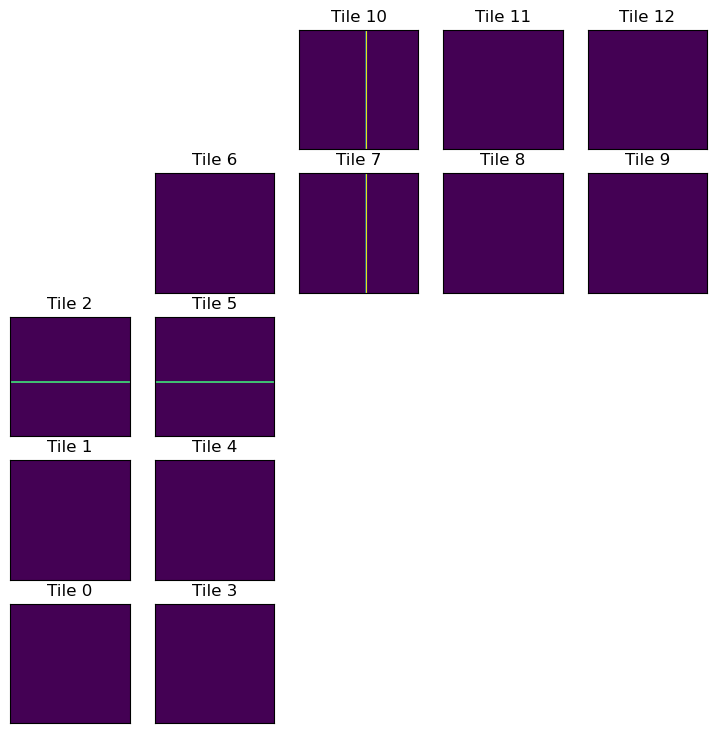

In [22]:
ecco.plot_tiles(exp_mask)
exp_mask_DA = ecco_ds['RHOAnoma'][0][0]*0; 
exp_mask_DA.name = 'exp_mask'
exp_mask_DA.values = exp_mask
exp_mask_DA;

In [23]:
exp_2D_xy_slice = ecco_ds['RHOAnoma'][0][0]

In [24]:
exp_mask_ins = np.where(exp_mask_DA.values.ravel() > 0)[0]
print(len(exp_mask_ins))

360


In [25]:
tt_lons = ecco_ds.XC.values.ravel()[exp_mask_ins]

In [26]:
#take time mean for now ...
rho_an_mean = ecco_ds['RHOAnoma'].mean('time').load()
uvs_an_mean = ecco_ds['UVELMASS'].mean('time').load()
vvs_an_mean = ecco_ds['VVELMASS'].mean('time').load()

In [27]:
rho_an_mean

<xarray.DataArray 'RHOAnoma' (k: 50, tile: 13, j: 90, i: 90)> Size: 21MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [-2.0494442, -2.0479505, -2.0454109, ..., -1.7322916,
          -1.7346987, -1.7370551],
         [-2.033381 , -2.0316837, -2.0284586, ..., -1.7349257,
          -1.7374048, -1.7399532],
         [-2.013232 , -2.0102575, -2.0060513, ..., -1.7387568,
          -1.7416211, -1.7448816]],

        [[-1.9920164, -1.9885906, -1.9843868, ..., -1.7435296,
          -1.7473657, -1.752214 ],
         [-1.9723355, -1.9694755, -1.965659 , ..., -1.7507143,
          -1.755853 , -1.7628719],
         [-1.9595001, -1.9582952, -1.9531146, ..., -1.761158 ,
          -1.7672573, -1.7760897],
...
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]], dtype=float32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03

In [28]:
rhos = []
uvs = []
vvs = []
for k in range(50):
    rho =rho_an_mean[k].values.ravel()[exp_mask_ins]
    uv =uvs_an_mean[k].values.ravel()[exp_mask_ins]
    vv =vvs_an_mean[k].values.ravel()[exp_mask_ins]
    rhos.append(rho)
    uvs.append(uv)
    vvs.append(vv)

print(len(rhos))
rhos = np.array(rhos)
uvs = np.array(uvs)
vvs = np.array(vvs)
rhos.shape

50


(50, 360)

In [29]:
rhos = np.array(rhos)
uvs = np.array(uvs)
vvs = np.array(vvs)
rhos.shape

(50, 360)

In [30]:
rhos[:,0]

array([-2.732897  , -2.6792173 , -2.5721428 , -2.4422843 , -2.3163183 ,
       -2.198695  , -2.089585  , -1.9881617 , -1.895322  , -1.8111159 ,
       -1.7338548 , -1.6612524 , -1.5904658 , -1.5177873 , -1.4381808 ,
       -1.3452837 , -1.230438  , -1.0844483 , -0.89874375, -0.6643868 ,
       -0.37463483, -0.0300162 ,  0.36245114,  0.7968495 ,  1.267578  ,
        1.7654343 ,  2.276684  ,  2.7877965 ,  3.2905345 ,  3.7829869 ,
        4.268281  ,  4.752644  ,  5.244845  ,  5.7578874 ,  6.3098745 ,
        6.9213314 ,  7.6102653 ,  8.389083  ,  9.264365  , 10.2396555 ,
       11.318532  , 12.505519  , 13.798013  , 15.18146   , 16.650179  ,
       18.197388  ,         nan,         nan,         nan,         nan],
      dtype=float32)

In [31]:
lon_indices = np.argsort(tt_lons)

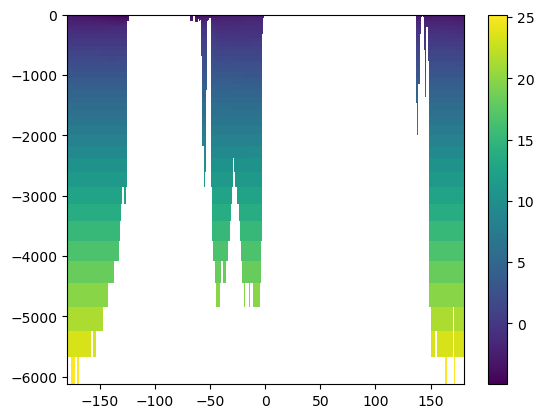

In [32]:
plt.pcolormesh(tt_lons[lon_indices], ecco_ds.Z, rhos[:,lon_indices])
plt.colorbar()

In [33]:
target_sig_levels

array([-11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,
        -6.5,  -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,
        -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,
         2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,
         7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,  10.5,  11. ,
        11.5,  12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,  15.5,
        16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,  20. ,
        20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ,  24.5,
        25. ,  25.5])

In [34]:
uv_dens = np.zeros((len(target_sig_levels),360))
vv_dens = np.zeros((len(target_sig_levels),360))

for i in range(360):
    j = lon_indices[i]
    vv_dens[:,j] = np.interp(target_sig_levels, rhos[:,j], vvs[:,j],left= np.nan,right= np.nan)
    uv_dens[:,j] = np.interp(target_sig_levels, rhos[:,j], uvs[:,j],left= np.nan,right= np.nan)

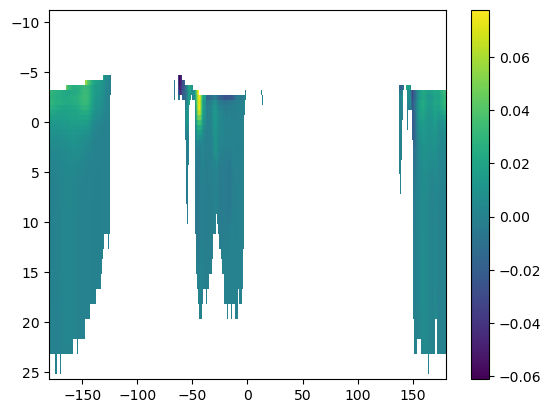

In [35]:
plt.pcolormesh(tt_lons[lon_indices], target_sig_levels, vv_dens[:,lon_indices])
plt.colorbar()
plt.gca().invert_yaxis()

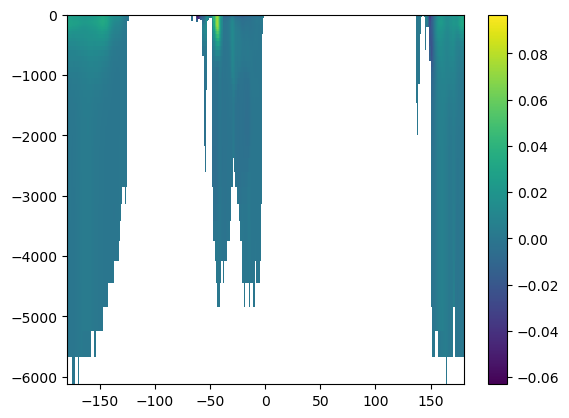

In [36]:
plt.pcolormesh(tt_lons[lon_indices], ecco_ds.Z, vvs[:,lon_indices])
plt.colorbar()

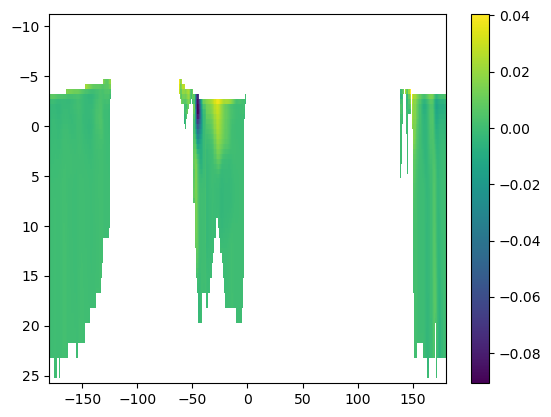

In [37]:
plt.pcolormesh(tt_lons[lon_indices],target_sig_levels, uv_dens[:,lon_indices])
plt.colorbar()
plt.gca().invert_yaxis()

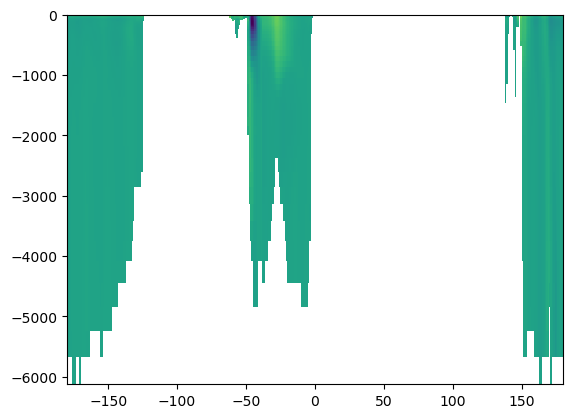

In [38]:
plt.pcolormesh(tt_lons[lon_indices], ecco_ds.Z, uvs[:,lon_indices])

In [39]:
ds_geom.drF

<xarray.DataArray 'drF' (k: 50)> Size: 200B
[50 values with dtype=float32]
Coordinates:
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Z        (k) float32 200B ...
Attributes:
    long_name:              distance between the top and bottom faces of a mo...
    units:                  m
    coverage_content_type:  modelResult
    standard_name:          cell_thickness
    comment:                Nominal grid cell thickness. Note: in the z* coor...

In [9]:
ds_vel_clim = ds_vel.groupby("time.month").mean('time')

NameError: name 'np' is not defined

In [8]:
10**1.57

37.15352290971726

In [40]:
sigma_mid = np.arange(-11,26,.5)
sigma_edge = np.arange(-11.25,26.25,.5)

dsig = np.zeros((len(target_sig_levels),360))
for sig in range(len(target_sig_levels)):
    for i in range(360):
        j = lon_indices[i]
        ddsig = 0
        for k in range(50):
            if sigma_edge[sig]<rhos[k,j]<sigma_edge[sig+1]:
                ddsig = ddsig + ds_geom.drF[k].values
        dsig[sig,j] = ddsig

In [41]:
ds_geom.drF.values

array([ 10.  ,  10.  ,  10.  ,  10.  ,  10.  ,  10.  ,  10.  ,  10.01,
        10.03,  10.11,  10.32,  10.8 ,  11.76,  13.42,  16.04,  19.82,
        24.85,  31.1 ,  38.42,  46.5 ,  55.  ,  63.5 ,  71.58,  78.9 ,
        85.15,  90.18,  93.96,  96.58,  98.25,  99.25, 100.01, 101.33,
       104.56, 111.33, 122.83, 139.09, 158.94, 180.83, 203.55, 226.5 ,
       249.5 , 272.5 , 295.5 , 318.5 , 341.5 , 364.5 , 387.5 , 410.5 ,
       433.5 , 456.5 ], dtype=float32)

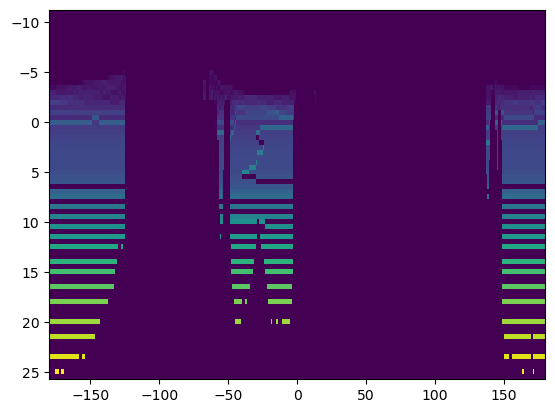

In [42]:
plt.pcolormesh(tt_lons[lon_indices], target_sig_levels, dsig[:,lon_indices])
plt.gca().invert_yaxis()

In [43]:
dxG_mask = np.array(ds_geom.dxG.values.ravel()[exp_mask_ins])
dyG_mask =  np.array(ds_geom.dyG.values.ravel()[exp_mask_ins])

In [70]:
#now turn flux to amoc
xvol = np.zeros((len(target_sig_levels),360))
yvol = np.zeros((len(target_sig_levels),360))
for sig in range(len(target_sig_levels)):
    yv = 0
    for i in range(360):
        j = lon_indices[i]
        yvol[sig,j] = vv_dens[sig,j]* dsig [sig,j]* dxG_mask[j]
        xvol[sig,j] = uv_dens[sig,j] * dsig[sig,j] * dyG_mask[j]

In [45]:
ds_vel['UVELMASS'].shape

(336, 50, 13, 90, 90)

In [46]:
ds_geom['drF'].shape

(50,)

In [47]:
ds_geom['dyG'].shape

(13, 90, 90)

In [48]:
x_vol = ds_vel['UVELMASS'] * ds_geom['drF'] * ds_geom['dyG']
x_vol.shape

(336, 50, 13, 90, 90)

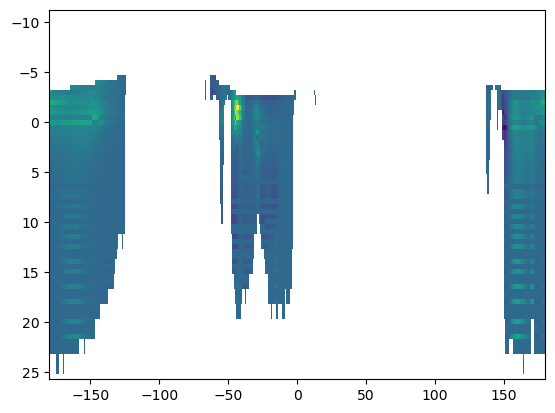

In [71]:
plt.pcolormesh(tt_lons[lon_indices], target_sig_levels, yvol[:,lon_indices])
plt.gca().invert_yaxis()

In [72]:
yvol.shape

(74, 360)

In [73]:
#global moc
yvol_glob = np.nansum(yvol, axis=1)
xvol_glob = np.nansum(xvol, axis=1)
yvol_glob.shape
trsp_sig_glob = (yvol_glob+xvol_glob)*10**-6

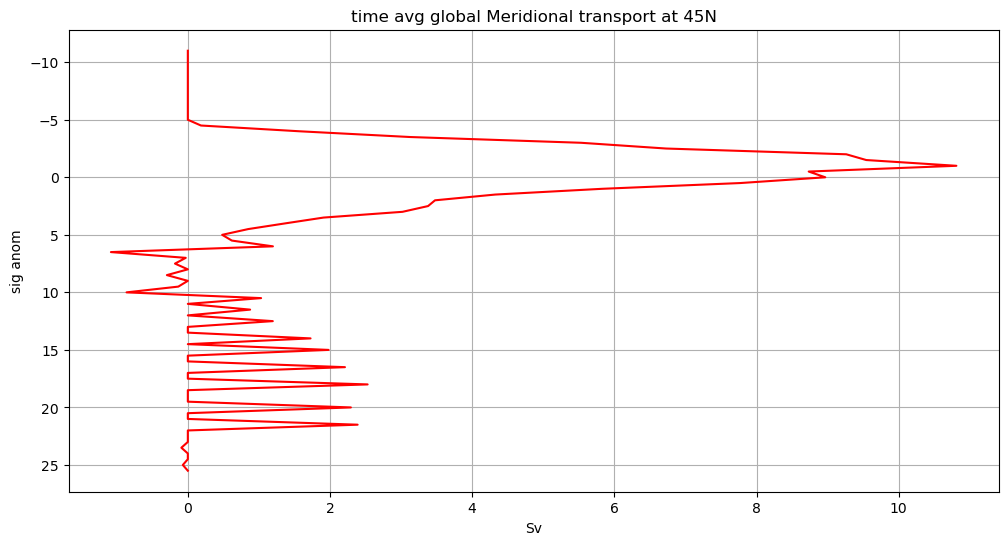

In [74]:
plt.figure(figsize=(12,6))
plt.plot(trsp_sig_glob,target_sig_levels[:],'r')
plt.grid()
plt.title('time avg global Meridional transport at 45N')
plt.ylabel('sig anom')
plt.xlabel('Sv')
plt.gca().invert_yaxis()
plt.show()


In [75]:
psi_moc_glob = trsp_sig_glob.cumsum()

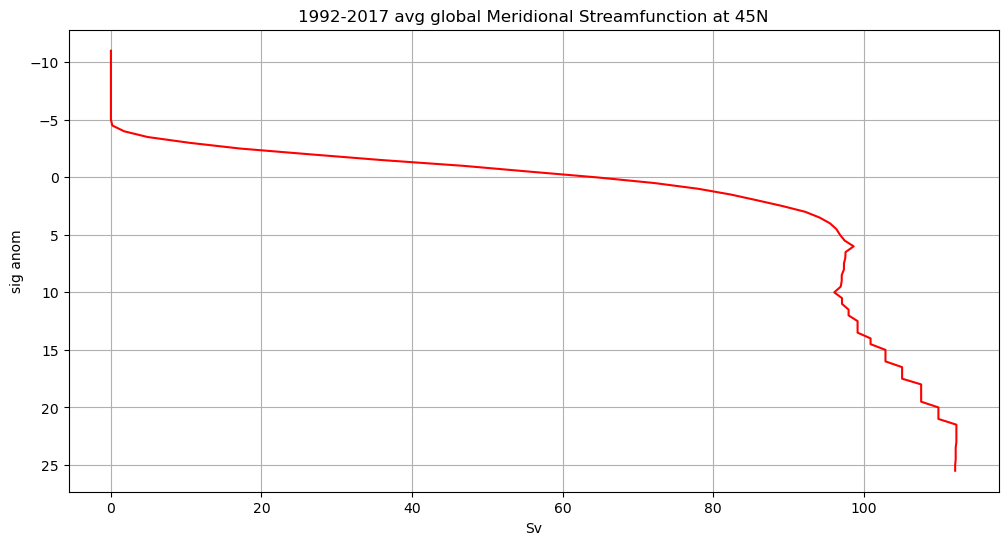

In [76]:
plt.figure(figsize=(12,6))
plt.plot(psi_moc_glob,target_sig_levels,'r')
plt.grid()
plt.title('1992-2017 avg global Meridional Streamfunction at 45N')
plt.ylabel('sig anom')
plt.xlabel('Sv')
plt.gca().invert_yaxis()
plt.show()

In [77]:
#atlantic better way
atl_maskW = ecco.get_basin_mask(basin_name='atlExt',mask=maskW.isel(k=0))
atl_maskS = ecco.get_basin_mask(basin_name='atlExt',mask=maskS.isel(k=0))

get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13

In [78]:
atlW_mask = np.array(atl_maskW.values.ravel()[exp_mask_ins])
atlS_mask =  np.array(atl_maskS.values.ravel()[exp_mask_ins])

In [79]:
yvol_atl = yvol*atlS_mask
xvol_atl = xvol*atlW_mask
yvol_atll = np.nansum(yvol_atl,axis=1)
xvol_atll = np.nansum(xvol_atl,axis=1)
trsp_sig_atl = (xvol_atll+yvol_atll)*10**-6

In [80]:
yvol_atll.shape

(74,)

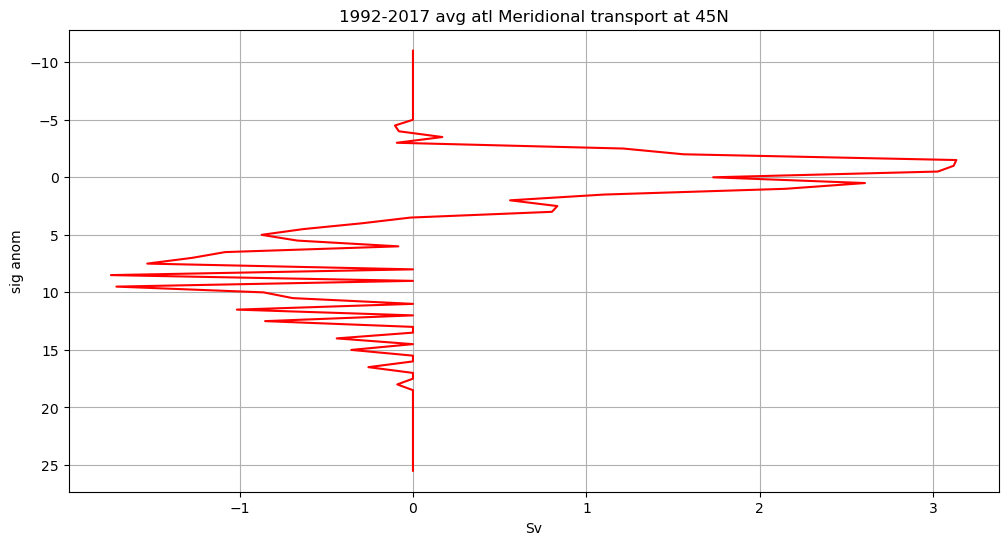

In [81]:
plt.figure(figsize=(12,6))
plt.plot(trsp_sig_atl,target_sig_levels,'r')
plt.grid()
plt.title('1992-2017 avg atl Meridional transport at 45N')
plt.gca().invert_yaxis()
plt.ylabel('sig anom')
plt.xlabel('Sv')
plt.show()

In [82]:
#psi_moc_atl = np.flipud(trsp_sig_atl)
psi_moc_atl = trsp_sig_atl.cumsum()
#psi_moc_atl = -1* np.flipud(psi_moc_atl)

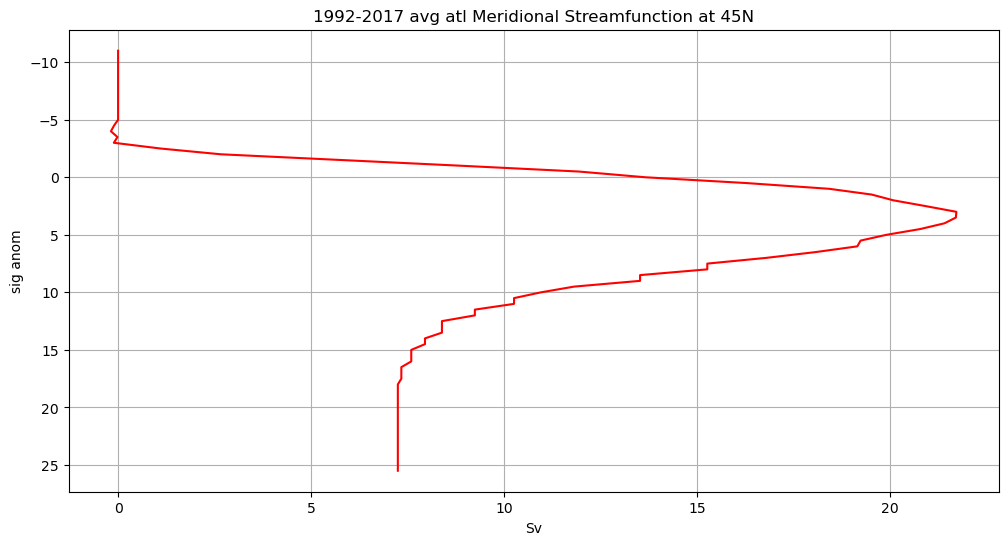

In [83]:
plt.figure(figsize=(12,6))
plt.plot(psi_moc_atl,target_sig_levels[:],'r')
plt.grid()
plt.title('1992-2017 avg atl Meridional Streamfunction at 45N')
plt.gca().invert_yaxis()
plt.ylabel('sig anom')
plt.xlabel('Sv')
plt.show()

In [ ]:
strm = ecco.calc_meridional_stf(ecco_ds,lat_vals=45,basin_name='atlExt')

In [ ]:
strm.compute()

In [ ]:
psi_mean = strm.psi_moc.mean('time')
trsp_mean = strm.trsp_z.mean('time')

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(trsp_mean,strm['Z'],'r')
plt.grid()
plt.title('1992-2017 avg Meridional transport at 45N')
plt.ylabel('m')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(psi_mean,strm['Z'],'r')
plt.grid()
plt.title('1992-2017 avg Meridional Streamfunction at 45N')
plt.ylabel('m')
plt.show()

In [65]:
#load dataset
geom_path = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_geom = xr.open_dataset(geom_path)

In [66]:
#define dx,dy
dx = ds_geom.dxG.rename({'j_g':'j'})
dy = ds_geom.dyG.rename({'i_g':'i'})
#calculate volume mask
volume_mask = ds_geom['drF']*dx*dy
#depth mask
depth_mask_temp = np.where(ds_geom.Z<-1000, 0, 1)
depth_mask_da = xr.DataArray(data=depth_mask_temp, dims={"k"},coords=dict(k=ds_geom['drF'].k.values))
temp = dx.copy()-dx.values+1
depth_mask = depth_mask_da*temp

In [67]:
volume_mask

<xarray.DataArray (k: 50, tile: 13, j: 90, i: 90)> Size: 21MB
array([[[[3.61729792e+09, 3.62814182e+09, 3.63806925e+09, ...,
          6.20330880e+08, 5.52320768e+08, 4.86872160e+08],
         [3.68981734e+09, 3.70086912e+09, 3.71098573e+09, ...,
          6.35753536e+08, 5.66449280e+08, 4.99754944e+08],
         [3.76428646e+09, 3.77553715e+09, 3.78583603e+09, ...,
          6.55898240e+08, 5.85368320e+08, 5.17494272e+08],
         ...,
         [3.33899817e+10, 3.33899817e+10, 3.33899817e+10, ...,
          3.33899817e+10, 3.33899817e+10, 3.33899817e+10],
         [3.43794156e+10, 3.43794156e+10, 3.43794156e+10, ...,
          3.43794156e+10, 3.43794156e+10, 3.43794156e+10],
         [3.51871918e+10, 3.51871918e+10, 3.51871918e+10, ...,
          3.51871918e+10, 3.51871918e+10, 3.51871918e+10]],

        [[3.59870382e+10, 3.59870382e+10, 3.59870382e+10, ...,
          3.59870382e+10, 3.59870382e+10, 3.59870382e+10],
         [3.68172728e+10, 3.68172728e+10, 3.68172728e+10, ...,
          3.68172728e+10, 3.68172728e+10, 3.68172728e+10],
         [3.78761175e+10, 3.78761175e+10, 3.78761175e+10, ...,
          3.78761175e+10, 3.78761175e+10, 3.78761175e+10],
...
          1.75337675e+12, 1.70450669e+12, 1.66634730e+12],
         [5.40280409e+12, 5.33711238e+12, 5.20535723e+12, ...,
          1.75337675e+12, 1.70450669e+12, 1.66634730e+12],
         [5.40280409e+12, 5.33711238e+12, 5.20535723e+12, ...,
          1.75337675e+12, 1.70450669e+12, 1.66634730e+12]],

        [[1.62959734e+12, 1.59245730e+12, 1.54675655e+12, ...,
          2.09588183e+10, 2.00736399e+10, 1.94237440e+10],
         [1.62959734e+12, 1.59245730e+12, 1.54675655e+12, ...,
          1.81503468e+10, 1.73130117e+10, 1.67137413e+10],
         [1.62959734e+12, 1.59245730e+12, 1.54675655e+12, ...,
          1.55078902e+10, 1.47155231e+10, 1.41638380e+10],
         ...,
         [1.62959734e+12, 1.59245730e+12, 1.54675655e+12, ...,
          1.70250060e+11, 1.66789235e+11, 1.63426894e+11],
         [1.62959734e+12, 1.59245730e+12, 1.54675655e+12, ...,
          1.70897637e+11, 1.67425458e+11, 1.64051272e+11],
         [1.62959734e+12, 1.59245730e+12, 1.54675655e+12, ...,
          1.71499831e+11, 1.68017068e+11, 1.64631839e+11]]]],
      dtype=float32)
Coordinates:
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    Z        (k) float32 200B ...
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12

In [68]:
depth_mask

<xarray.DataArray (k: 50, tile: 13, j: 90, i: 90)> Size: 42MB
array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12